**Aim**: investigate and visualize the connections between drugs and genes using a knowledge graph constructed from datasets of the CRISPRi + drug screen experiments.

___

Similar works:

- https://github.com/AstraZeneca/skywalkR-graph-features

> KR4SL: knowledge graph reasoning for explainable prediction of synthetic lethality 
> - https://doi.org/10.1093/bioinformatics/btad261

- https://github.com/mims-harvard/PrimeKG#dataloader-therapeutics-data-commons

- https://tdcommons.ai/multi_pred_tasks/ppi/

___

List drug names:
- PARP INHIBITOR
    - Olaparib
- ATM INHIBITOR
    - AZD0156
- ATR INHIBITOR
    - AZD6738
- WEE1 INHIBITOR
    - AZD1775
- DNA-PK INHIBITOR
    - AZD7648

In [1]:
drug_names = {
    'Pi': 'PARPi',
    'Ri': 'ATRi',
    'Wi': 'WEE1i',
    'Mi': 'ATMi',
    'Ki': 'DNAPKi',
    'PiRi': 'PARPi+ATRi',
    'PiWi': 'PARPi+WEE1i',
    'PiMi': 'PARPi+ATMi',
    'PiKi': 'PARPi+DNAPKi'
}


In [2]:
import numpy as np 
import pandas as pd
import anndata as ad
import screenpro as scp

from screenpro.load import loadScreenProcessingData

In [3]:
# import sys
# sys.path.append("/data_gilbert/home/aarab/FunGI")
# from search import *

In [4]:
# from tdc.multi_pred import PPI
# data = PPI(path='../../tdc-data', name='HuRI')

In [5]:
import matplotlib.pyplot as plt

from matplotlib import font_manager as fm
from matplotlib import rcParams

import matplotlib

matplotlib.use('cairo')

# font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# for font_file in font_files:
#     fm.fontManager.addfont(font_file)
# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.sans-serif'] = 'Helvetica'
rcParams['font.family'] = ['Helvetica']


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Data Preparation

### Get phenotype scores

In [6]:
screen = scp.load._read_screen_pkl('../screens/A549_CRISPRi_v2_screens')

### Build a single KG

- https://github.com/abearab/DDRi/issues/3

In [7]:
from tdc.utils.knowledge_graph import KnowledgeGraph, build_KG

In [8]:
screen.listPhenotypeScores(run_name='compare_guides')

['gamma:DMSO_vs_T0',
 'tau:Pi_vs_T0',
 'rho:Pi_vs_DMSO',
 'tau:Ri_vs_T0',
 'rho:Ri_vs_DMSO',
 'tau:PiRi_vs_T0',
 'rho:PiRi_vs_DMSO',
 'tau:Mi_vs_T0',
 'rho:Mi_vs_DMSO',
 'tau:PiMi_vs_T0',
 'rho:PiMi_vs_DMSO',
 'tau:Wi_vs_T0',
 'rho:Wi_vs_DMSO',
 'tau:PiWi_vs_T0',
 'rho:PiWi_vs_DMSO',
 'tau:Ki_vs_T0',
 'rho:Ki_vs_DMSO',
 'tau:PiKi_vs_T0',
 'rho:PiKi_vs_DMSO']

In [9]:
def getTreatmentKG(screen,treatment,perturbation, drug_names=drug_names,threshold=6):
    
    df = screen.getPhenotypeScores(
        run_name='compare_guides',
        phenotype_name=f'rho:{treatment}_vs_DMSO',
        threshold=threshold,
        pvalue_col = 'ttest pvalue'
    )    
        
    df = df[['target','label','combined_score']].query('label not in ["target_non_hit","negative_control"]').reset_index(drop=True)
    
    kg = build_KG(
        indices = df.index,# a list to assign row names of output data frame
        relation = perturbation, # a list or string to assign values
        display_relation= df.label,# a list or string to assign values

        x_id = drug_names[treatment],# a list or string to assign values
        x_type = 'Drug',# a list or string to assign values
        x_name = drug_names[treatment],# a list or string to assign values
        x_source = 'AstraZeneca',# a list or string to assign values

        y_id = df.target,# a list or string to assign values
        y_type = 'gene',# a list or string to assign values
        y_name = df.target,# a list or string to assign values
        y_source = 'NCBI'# a list or string to assign values
    )

    kg.df['score'] = df['combined_score'] # .abs()
    
    return kg

In [10]:
DDRi_screens_A549_CRISPRi_kg = pd.concat([
    getTreatmentKG(screen,treatment=t,perturbation='A549_CRISPRi').df 
    for t in list(drug_names.keys())
]).reset_index(drop=True)

DDRi_screens_A549_CRISPRi_kg = KnowledgeGraph(DDRi_screens_A549_CRISPRi_kg)

In [11]:
# Ca_A549_kg = pd.concat([
#     getTreatmentKG(Ca_A549,treatment=t,perturbation='A549_CRISPRa',rep_name='Rep1').df
#     for t in list(Ca_A549.comparisons.keys())
# ]).reset_index(drop=True)

# Ca_k562_kg = pd.concat([
#     getTreatmentKG(Ca_k562,treatment=t,perturbation='K562_CRISPRa').df
#     for t in list(Ca_k562.comparisons.keys())
# ]).reset_index(drop=True)

In [12]:
# DDRi_screens_kg = pd.concat([
#     Ci_kg,
#     Ca_A549_kg,
#     Ca_k562_kg,
# ]).reset_index(drop=True)

# DDRi_screens_kg = KnowledgeGraph(DDRi_screens_kg)

In [13]:
# DDRi_screens_kg.df.to_csv('DDRi_screens_kg.csv',index=False)

___

In [14]:
# DDRi_screens_A549_CRISPRi_kg = DDRi_screens_kg.copy()

# DDRi_screens_A549_CRISPRi_kg.run_query('relation=="A549_CRISPRi"')

# DDRi_screens_A549_CRISPRi_kg.df.to_csv('DDRi_screens_A549_CRISPRi_kg.csv',index=False)

___

In [15]:
DDRi_screens_rho_sen_kg = DDRi_screens_A549_CRISPRi_kg.copy()

DDRi_screens_rho_sen_kg.run_query('display_relation=="sensitivity_hit"')

In [16]:
DDRi_screens_rho_res_kg = DDRi_screens_A549_CRISPRi_kg.copy()

DDRi_screens_rho_res_kg.run_query('display_relation=="resistance_hit"')

## Graph Analysis and Visualization

Relevant resources:
- https://github.com/cytoscape/py2cytoscape

In [17]:
import networkx as nx

In [18]:
from gprofiler import GProfiler

In [19]:
import random
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
import igraph as ig

In [203]:
def build_graph(kg,verbose=True):

    gr = ig.Graph.TupleList(
        kg.df[['x_id','y_id','score']].itertuples(index=False), 
        directed=False, 
        weights=True
    )
    
    gr.es['phenotype'] = kg.df['display_relation'].tolist()
    # one-hot encoding of the phenotype
    gr.es['phenotype_onehot'] = pd.get_dummies(kg.df['display_relation']).values.tolist()

    gr.vs['type'] = [
        'drug' if node in kg.df.x_name.unique() else 'gene' 
        for node in gr.vs['name']
    ]
    gr.vs['degree'] = gr.degree()

    gr.vs['color'] = ['#FF5733' if t == 'drug' else '#33C1FF' for t in gr.vs['type']]
    gr.vs['shape'] = ['rectangle' if t == 'drug' else 'circle' for t in gr.vs['type']]
    gr.es['color'] = ['#3182bd' if p == 'sensitivity_hit' else '#de2d26' for p in gr.es['phenotype']]    
    
    if verbose: get_graph_features(gr)
    
    return gr


def get_graph_features(g, out=None):
    print(g.summary(), '\n')
    print("Number of vertices in the graph:", g.vcount())
    print("Number of edges in the graph", g.ecount())
    print("Is the graph directed:", g.is_directed())
    print("Maximum degree in the graph:", g.maxdegree())

    top_nodes = g.vs.select(_degree=g.maxdegree())["name"]
    print("Node name with Maximum degree:", top_nodes)

In [204]:
def plot_drug_gene_graph(g, ax):
    """
    Plot a drug-gene interaction graph.
    
    Calculate betweenness centrality for vertices and edges and visualize the graph with color-coded nodes and edges.

    Args:
        g (igraph.Graph): The graph to plot.
        ax (matplotlib Axes): Axes object for plotting the graph.
        d_thr (int): Degree threshold for highlighting nodes.

    Returns:
        igraph.Graph: Graph with visual attributes.
    """

    # Assign node attributes
    degrees = g.degree()
    node_types = g.vs["type"]

    g.vs["size"] = [30 if d > 10 else d * 3 for d in degrees]  # Increased size for better visibility
    g.vs["shape"] = ["rectangle" if nt == "drug" else "circle" for nt in node_types]
    g.vs["label"] = [name if d > 10 else "" for d, name in zip(degrees, g.vs["name"])]

    # Assign edge attributes
    g.es["color"] = [
        "blue" if phenotype == "sensitivity_hit" else "gray"
        for phenotype in g.es["phenotype"]
    ]
    g.es["width"] = [2 if phenotype == "sensitivity_hit" else 1 for phenotype in g.es["phenotype"]]  # Thicker edges for important relationships

    # Actually plot the graph
    visual_style = {
        "layout": g.layout("fruchterman_reingold"),
        "bbox": (800, 800),  # Increased size for better layout
        "margin": 50,
        "target": ax,
        "vertex_label_size": 10,  # Increased label size for better readability
        "edge_label": g.es["phenotype"],  # Optional: add edge labels
        "edge_label_size": 8,  # Size for edge labels
    }

    ig.plot(g, **visual_style)

    return g

### Show the full graph

First, we need to show the global structure of the knowledge graph.

In [205]:
gr_all = build_graph(DDRi_screens_A549_CRISPRi_kg,verbose=True)

IGRAPH UNWT 2458 5278 -- 
+ attr: color (v), degree (v), name (v), shape (v), type (v), color (e), phenotype (e), phenotype_onehot (e), weight (e) 

Number of vertices in the graph: 2458
Number of edges in the graph 5278
Is the graph directed: False
Maximum degree in the graph: 948
Node name with Maximum degree: ['PARPi+ATRi']


In [206]:
g = gr_all.copy()



In [207]:
# # Draw a large circular layout of the graph using igraph

# fig, ax = plt.subplots(figsize=(10, 10))

# ig.plot(
#     g, 
#     target=ax, 
#     vertex_color=g.vs['color'], 
#     vertex_shape=g.vs['shape'], 
#     vertex_size=10, 
#     edge_color=g.es['color'], 
#     edge_width=0.5,
#     layout='circle',
#     bbox=(0, 0, 1, 1),
#     margin=0.1
# )

In [208]:
gr_sen = build_graph(DDRi_screens_rho_sen_kg)

IGRAPH UNWT 1611 3640 -- 
+ attr: color (v), degree (v), name (v), shape (v), type (v), color (e), phenotype (e), phenotype_onehot (e), weight (e) 

Number of vertices in the graph: 1611
Number of edges in the graph 3640
Is the graph directed: False
Maximum degree in the graph: 636
Node name with Maximum degree: ['DNAPKi']


In [209]:
gr1 = gr_sen.copy()

## filter by degree
# https://codereview.stackexchange.com/questions/284246/deletion-of-nodes-of-degree-1-from-a-python-igraph-graph
gr1.delete_vertices({v for v in gr1.vs.select(_degree_le=2)})

get_graph_features(gr1)

IGRAPH UNWT 520 2184 -- 
+ attr: color (v), degree (v), name (v), shape (v), type (v), color (e), phenotype (e), phenotype_onehot (e), weight (e) 

Number of vertices in the graph: 520
Number of edges in the graph 2184
Is the graph directed: False
Maximum degree in the graph: 378
Node name with Maximum degree: ['PARPi+DNAPKi']


___

In [233]:
gr = gr_all.copy()

ValueError: RGBA sequence should have length 3 or 4

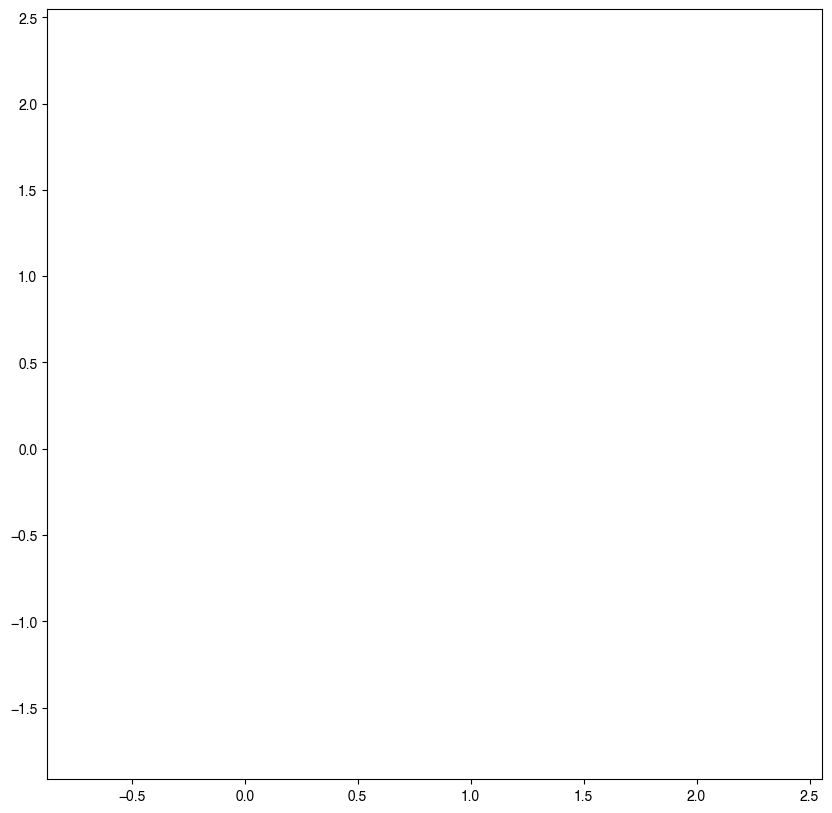

In [243]:
# Community Detection
communities = gr.community_multilevel(
    weights=[np.abs(w) for w in gr.es['weight']],
)

# Add attributes of node type into the communities object

# Assign community membership to vertices
gr.vs['community'] = communities.membership

# Plot the graph with gene communities
fig, ax = plt.subplots(figsize=(10, 10))

# Create a layout for the graph
layout = gr.layout_fruchterman_reingold()
# Create a new graph with additional links for community clustering
edges = []
weights = []

for community in set(gr.vs['community']):
    members = [v.index for v in gr.vs if v['community'] == community]
    for i in range(len(members)):
        for j in range(i + 1, len(members)):
            edges.append((members[i], members[j]))
            weights.append(10)  # High weight for within-group links

# Add original edges with lower weight
for edge in gr.es:
    edges.append((edge.source, edge.target))
    weights.append(1)  # Small weight for original links

# Create a new graph with the modified edges
clustered_graph = ig.Graph(edges=edges, directed=False)
clustered_graph.es['weight'] = weights

# Create a layout based on the clustered graph
layout = clustered_graph.layout_fruchterman_reingold()

# plot edges of the original graph
ig.plot(
    gr,
    vertex_size=0,
    vertex_width=0,
    edge_width=0.1,
    edge_size=0.1,
    edge_color=gr.es['color'],
    alpha=0.5,
    target=ax,
    layout=layout,
)

# plot drug and gene nodes

ig.plot(
    gr,
    vertex_size=[10 if v['type'] == 'drug' else 0 for v in gr.vs],
    vertex_width=0.1,
    vertex_shape='rectangle',
    frame_color='black',
    edge_size=0,
    edge_width=0,
    edge_color='black',
    target=ax,
    layout=layout,
)

ig.plot(
    gr,
    vertex_size=[v['degree'] if v['type'] == 'gene' else 0 for v in gr.vs],
    vertex_width=0.1,
    vertex_shape='circle',
    edge_size=0,
    edge_width=0,
    target=ax,
    layout=layout,
)

# plot communities
ig.plot(
    communities,
    edge_size=0,
    edge_width=0,
    vertex_size=0,
    vertex_width=0,
    target=ax,
    layout=layout,
    mark_groups = True
)

ax.axis('off')  

plt.title("Gene Communities", fontsize=16)
plt.savefig('gene_communities.pdf', bbox_inches='tight')
plt.show()

In [197]:
# Get gene nodes and communities
genes = [v for v in gr.vs if v['type'] == 'gene']
gene_communities = pd.DataFrame({
    'gene': [v['name'] for v in genes],
    'community': [v['community'] for v in genes]
})

subnetworks = gene_communities['community'].value_counts()

print(f"Identified {len(subnetworks)} subnetworks of genes")

Identified 6 subnetworks of genes


In [198]:
gp = GProfiler(return_dataframe=True)

results = []

for cluster_id in subnetworks.index:
    cluster_genes = gene_communities[gene_communities['community'] == cluster_id]['gene'].tolist()
    if len(cluster_genes) < 5:
        continue

    enriched = gp.profile(organism='hsapiens', query=cluster_genes,
                          sources=["GO:BP", "REAC"], no_evidences=False)
    enriched['cluster'] = cluster_id
    enriched['genes_in_cluster'] = len(cluster_genes)
    results.append(enriched)

all_enriched = pd.concat(results)
print("Saved enrichment results for all subnetworks")

Saved enrichment results for all subnetworks


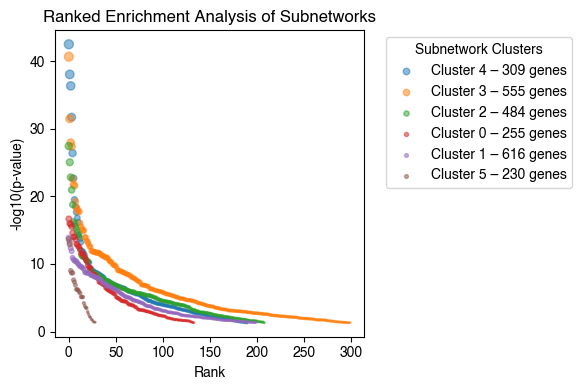

In [199]:
%matplotlib inline
# plot a rank plot p-value vs. -log10(p-value)
fig, ax = plt.subplots(figsize=(6, 4))

all_enriched_sorted = all_enriched.sort_values('p_value')

for cluster_id in all_enriched_sorted['cluster'].unique():
    cluster_data = all_enriched_sorted[all_enriched_sorted['cluster'] == cluster_id]
    ax.scatter(
        range(len(cluster_data)), 
        -np.log10(cluster_data['p_value']), 
        label=f'Cluster {cluster_id} – {cluster_data["genes_in_cluster"].iloc[0]} genes',
        s= -np.log10(cluster_data['p_value']),
        alpha=0.5
    )

plt.legend(title='Subnetwork Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Rank')
plt.ylabel('-log10(p-value)')
plt.title('Ranked Enrichment Analysis of Subnetworks')
plt.tight_layout()
plt.show()

In [200]:
# plot subnetwork drug-gene graphs

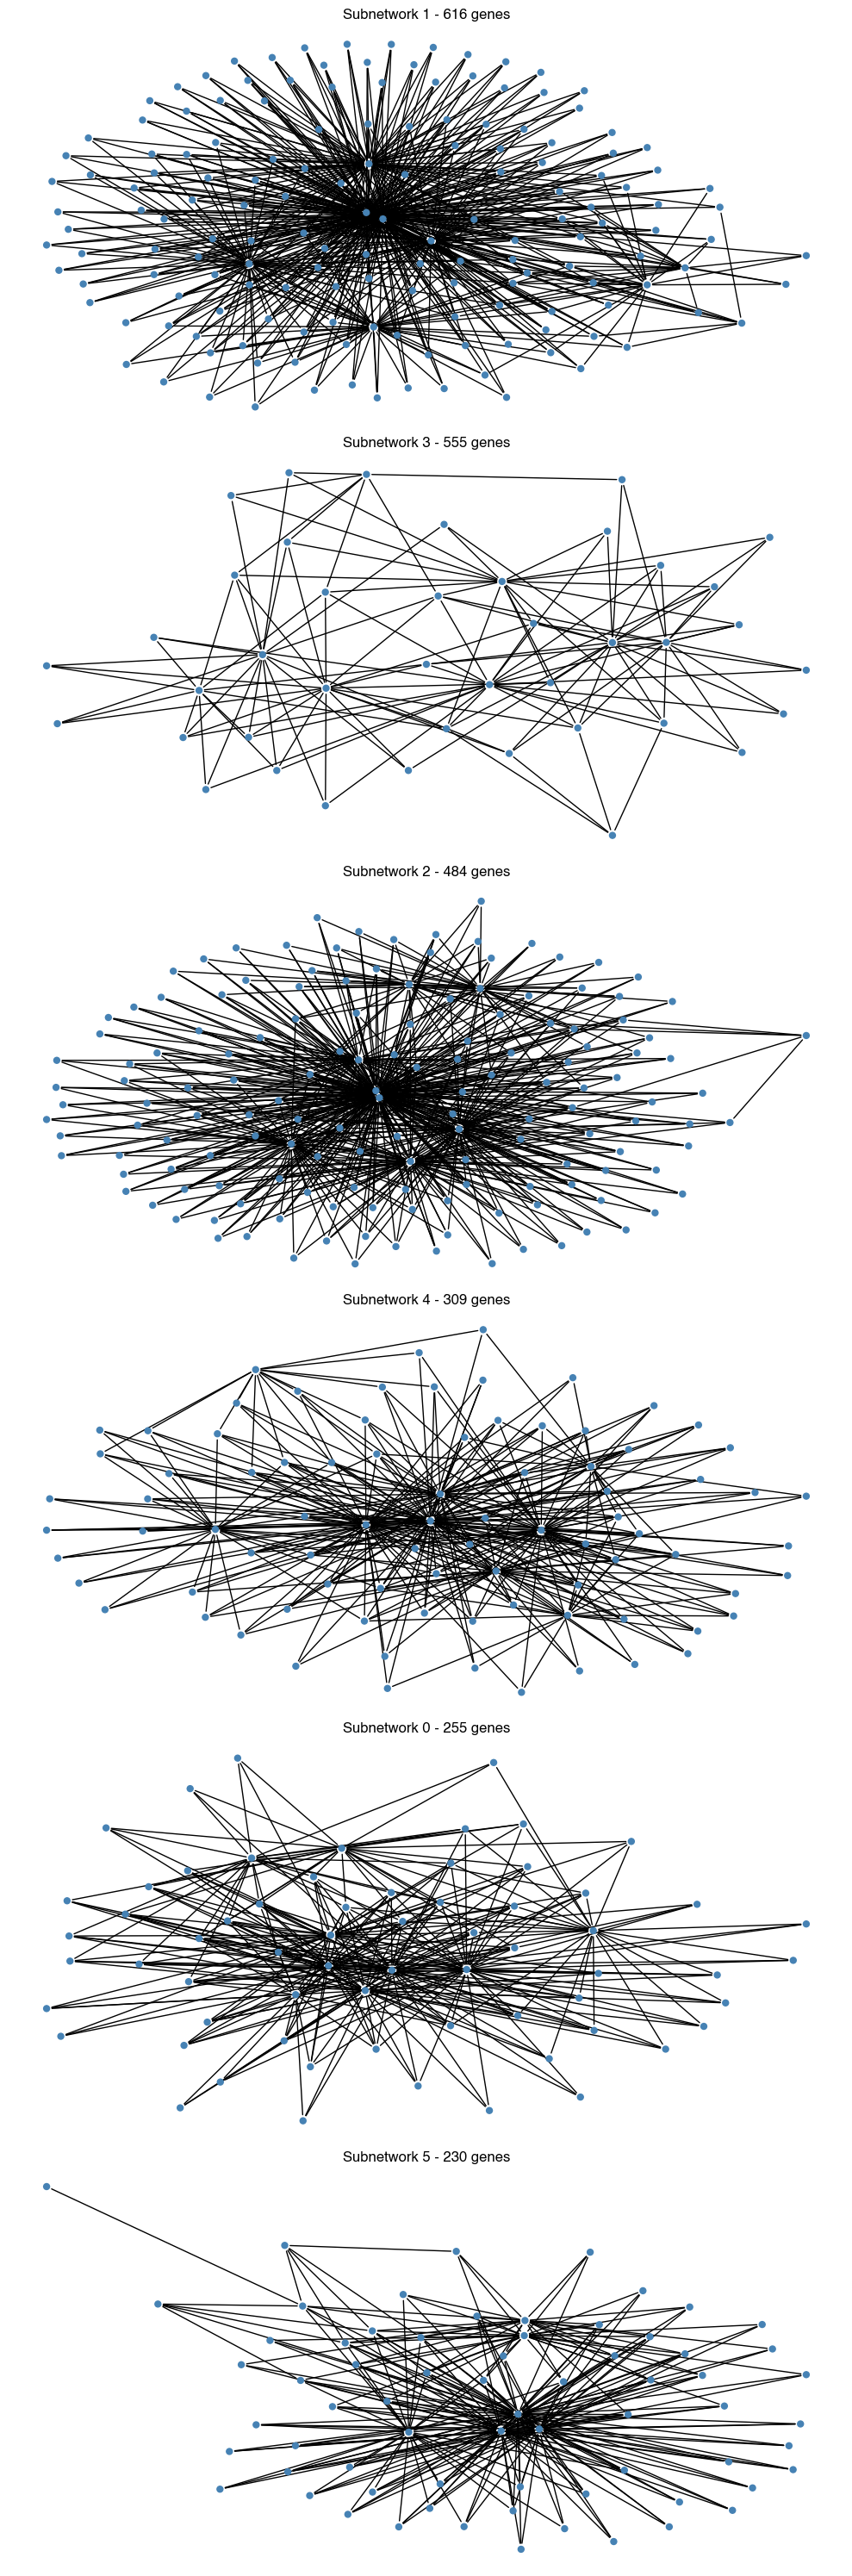

In [201]:
%matplotlib inline 
fig, axs = plt.subplots(
    nrows=len(subnetworks), 
    ncols=1, 
    figsize=(10, 5 * len(subnetworks))
)

for i, cluster_id in enumerate(subnetworks.index):
    cluster_genes = gene_communities[gene_communities['community'] == cluster_id]['gene'].tolist()
    if len(cluster_genes) < 5:
        continue

    subgraph = gr1.subgraph([v.index for v in gr1.vs if v['name'] in cluster_genes or v['type'] == 'drug'])
    
    ax = axs[i] if len(subnetworks) > 1 else axs
    plot_drug_gene_graph(subgraph, ax)
    
    ax.set_title(f'Subnetwork {cluster_id} - {len(cluster_genes)} genes')
    ax.axis('off')

fig.tight_layout(h_pad=1)
plt.show()

In [86]:
# scp.pl._utils.yellow_blue

In [73]:
# %matplotlib inline 
# fig, ax = plt.subplots(figsize=(10, 10))

# gr = plot_drug_gene_graph(gr, ax)

# plt.tight_layout()
# plt.show()


### Plot

In [53]:
# def plot_betweenness(g, ax, cax1, cax2, d_thr = 9):
#     '''Plot vertex/edge betweenness, with colorbars

#     Args:
#         g: the graph to plot.
#         ax: the Axes for the graph
#         cax1: the Axes for the vertex betweenness colorbar
#         cax2: the Axes for the edge betweenness colorbar
#     '''
#     vertex_betweenness = g.betweenness()
#     edge_betweenness = g.edge_betweenness()

#     # Rescale betweenness to be between 0.0 and 1.0
#     scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
#     scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
#     print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
#     print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

#     # Define mappings betweenness -> color
#     cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
#     cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

#     # Plot graph
#     g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]

#     g.vs["frame_color"] = [
#         'red' if d >= d_thr and nType != 'drug' else 'black' for d,nType in zip(g.vs.degree(),g.vs['nodeType'])
#     ]
    
#     # frame_colors = []
#     # for d,name,nType in zip(g.vs.degree(),g.vs['name'], g.vs['nodeType']):
#     #     if d >= d_thr and nType != 'drug':
#     #         frame_colors.append('red')
#     #     elif d < d_thr and nType != 'drug':
#     #         frame_colors.append('black')
#     #     elif '+' in name and nType == 'drug':
#     #         frame_colors.append('green')
#     #     else:
#     #         frame_colors.append('blue')
            
#     # g.vs["frame_color"] = frame_colors
    
    
#     g.vs["frame_width"] = [
#         3 if d >= d_thr and nType != 'drug' else 1 for d,nType in zip(g.vs.degree(),g.vs['nodeType'])
#     ]
    
#     s_scale = 2
#     g.vs["size"]  = [20 * s_scale if d > 10 else d * s_scale for d in g.vs.degree()]
#     g.vs['shape'] = ['rectangle' if nType is 'drug' else 'circle' for nType in gr.vs['nodeType']]
#     g.vs['label'] = [name if d > 10 else '' for d,name in zip(g.vs.degree(), g.vs['name'])]

#     g.es["size"] = [betweenness for betweenness in scaled_edge_betweenness]
#     g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
#     g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))

#     # g.layout_fruchterman_reingold(niter=10000)
#     # g.layout_reingold_tilford_circular(mode='in')
    
#     ig.plot(
#         g,
#         target=ax,
#         layout="fruchterman_reingold",
#         keep_aspect_ratio=True,
#     )

#     # Color bars
#     norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
#     norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
#     plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
#     plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')
    
#     return g

### Annotated graph to highlight PRDX1
<!-- - color `edge` by rho score direction 
- weight`edge` by rho score values
- circle gene `nodes` and square treatment nodes
- size gene `nodes` give a confidence value from the p-values
    - maybe average of `-log10(p-values)`
    - https://stats.stackexchange.com/questions/78596/when-combining-p-values-why-not-just-averaging
- export data for cytoscape visualization -->

In [64]:
gr = gr1.copy()

# gr = gr.es.subgraph([
#     (e < pd.Series(gr1.edge_betweenness()).quantile(.1)) |
#     (e > pd.Series(gr1.edge_betweenness()).quantile(.9)) 
#     for e in gr.edge_betweenness()
# ])

In [65]:
[n for d,n in zip(gr.degree(),gr.vs['name']) if d >= 9 and 'i' not in n]

['CDK12', 'MCPH1', 'PRDX1', 'RAD9A', 'RFC5', 'XRCC3']

In [66]:
# gr = gr.simplify()

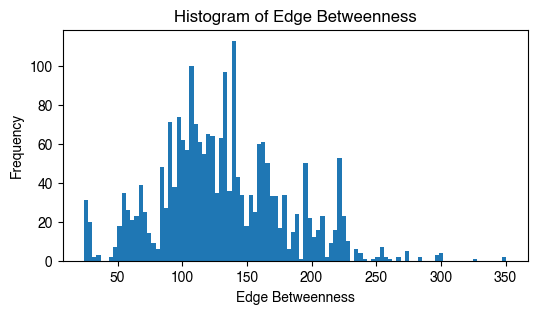

In [67]:
%matplotlib inline 
plt.figure(figsize=(6, 3))

counts, bins, patches = plt.hist(gr.edge_betweenness(), bins=100)

plt.xlabel('Edge Betweenness')
plt.ylabel('Frequency')
plt.title('Histogram of Edge Betweenness')
plt.show()

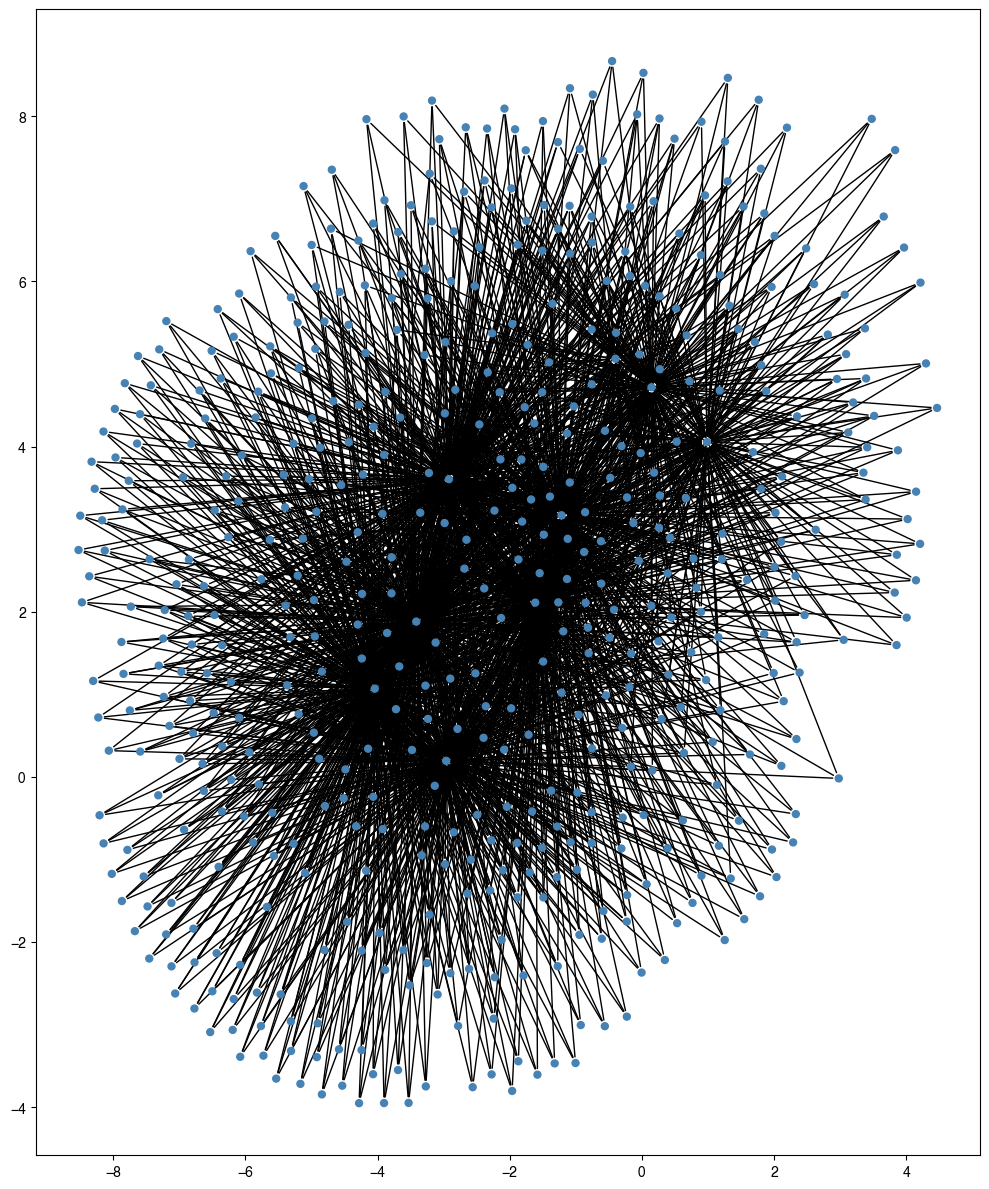

In [68]:
%matplotlib inline 
fig, axs = plt.subplots(
    figsize=(10, 12),
)

gr_plot = plot_drug_gene_graph(gr, axs)

fig.tight_layout(h_pad=1)
# plt.savefig("Fig-2C.pdf")
plt.show()

In [283]:
# cyto = ig.drawing.graph.CytoscapeGraphDrawer()

# cyto.draw(graph=gr)

In [194]:
# from pyvis.network import Network

# nt = Network('500px', '500px',notebook=True)
# nt.from_nx(gr_plot.to_networkx())
# nt.show('test.html')

# 

In [22]:
from watermark import watermark
print(
    watermark()
)

Last updated: 2025-07-31T15:59:23.350433-07:00

Python implementation: CPython
Python version       : 3.9.23
IPython version      : 8.15.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [23]:
print(
    watermark(iversions=True, globals_=globals())
)

watermark : 2.5.0
numpy     : 1.26.4
screenpro : 0.5.1
pandas    : 2.3.1
anndata   : 0.10.9
matplotlib: 3.9.2



___